In [1]:
# Author: Matthew Dixon
# Version: 1.0 (25.8.2018)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0

## An Introduction to LSTMs

### Overview
- This notebook provides an example of how TensorFlow can be used to train and test a Long-Short Term Memory (a type of recurrent neural network) architecture for regression. The example dataset is for predicting mid-price movements from the time series of limit order book updates. 

- Recurrent neural networks are well suited to time series modeling. Unlike typical time series methods, e.g. GARCH, there are no parameteric assumptions on the distribution of the predictors, and non-linear relationships between response and predictors can be captured without over-fitting. 

- In our example, the goal of the LSTM predictor is to predict the mid-price from one or more order book variables.

#### Statistician's note
- We choose to build a model which provides strong predictive power, in favor of explantory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' -identifying the relevant features to include in the model. Elastic net or LARS are common techniques for automatic variable selection. Other techniques, commonly used with neural network architectures include auto-encoders. 
- In this tutorial, we assume that we've already identifed the relevant set of features. 
- Our primary concern in assessing the extent to which the model is over-fitting.

In [7]:
%matplotlib inline

In [25]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error, f1_score

Import the necessary set of modules from Keras

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.models import load_model

### Example Data
- The example dataset is a chronologically ordered time series. Each observation is recorded at each limit order book update. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- For simplicity, since the timestamps are not important for this tutorial, an integer index has been used for the Pandas Dataframe. A real dataset would typically be indexed by a unique timestamp. 

- Each observation $X$ has three variables (a.k.a. features) representing the liquidity and best limit order price quotes in the book. To predict whether the mid-price will tick-down, remain the same or tick-up, each observation is labelled by the categorical response variable $Y\in\{-1,0,1\}$ respectively.  


Loading the Pandas Dataframe, viewing the first ten rows and the distribution of the labels:

In [6]:
df = pd.read_csv('../../data/HFT.csv')

In [7]:
df.head()

,feature_1,feature_2,feature_3,label
0,0.515301,0.72,0.710953,0
1,0.515301,0.72,0.710953,0
2,0.515301,0.72,0.710953,0
3,0.515301,0.72,0.710953,0
4,0.515301,0.72,0.710953,0


# LSTM Model Regression
We consider a prediction prkblem where the response is a continuous variable, the 'smart price', and the observations of predictors are a uni-variate time series. The smart price is the volume weighted mid-price, represented by feature_3 in our dataset.

## Data preparation

In [ ]:
use_features = ['feature_3'] # volume weighted mid-price
target = 'feature_3'
n_steps = 10 # number of lags to include in the model

In [11]:
train_weight = 0.8
split = int(len(df)*train_weight)

In [12]:
# Standardize the data

In [12]:
df_train = df.iloc[:split]
std_df_train = df_train[use_features].apply(lambda x: (x - x.mean()) / x.std())
df_test = df.iloc[split:]
std_df_test = df[use_features].apply(lambda x: (x - x.mean()) / x.std()).iloc[split:]

### Data formatting for LSTMs

Let's define the following function for reshaping the data into times series classification format. For example, consider a univariate time series of increasing integers

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15

In [13]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [14]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(std_df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

In [15]:
col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

In [16]:
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].as_matrix()
x_train_reg = np.reshape(x_train_reg.as_matrix(), (x_train_reg.shape[0], x_train_reg.shape[1] / len(use_features), len(use_features)))

In [17]:
x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(std_df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

In [18]:
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].as_matrix()
x_test_reg = np.reshape(x_test_reg.as_matrix(), (x_test_reg.shape[0], x_test_reg.shape[1]/len(use_features), len(use_features)))

In [19]:
print x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape

(826815, 10, 1) (826815, 1) (206697, 10, 1) (206697, 1)


### Model Specification

Let's configure and fit a LSTM to our univariate data

In [20]:
reg_model = Sequential()
reg_model.add(LSTM(n_steps, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
reg_model.add(Dense(1))
reg_model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
last_epoch_th = 0

In [24]:
%%time
reg_model.fit(x_train_reg, y_train_reg, epochs=5, batch_size=500, verbose=1, initial_epoch = last_epoch_th)

Epoch 1/5
826815/826815 [==============================] - 39s 47us/step - loss: 1.6989e-05
Epoch 2/5
826815/826815 [==============================] - 39s 47us/step - loss: 1.6663e-05
Epoch 3/5
826815/826815 [==============================] - 39s 47us/step - loss: 1.6484e-05
Epoch 4/5
826815/826815 [==============================] - 39s 47us/step - loss: 1.6328e-05
Epoch 5/5
826815/826815 [==============================] - 39s 47us/step - loss: 1.6225e-05


In [ ]:
# optionally save the model
reg_model.save('model/lstm_regression_HFT.hdf5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [ ]:
# returns a compiled model
# identical to the previous one
reg_model = load_model('model/lstm_regression_HFT.hdf5')

### Prediction

We shall now apply the model on the training set and the test set, separately. We can then informally assess the extent
of over-fitting.

In [27]:
%%time
# make predictions
pred_train = reg_model.predict(x_train_reg, verbose=1)
pred_test = reg_model.predict(x_test_reg, verbose=1)

206697/206697 [==============================] - 24s 117us/step
CPU times: user 2min 22s, sys: 2min 2s, total: 4min 25s
Wall time: 2min 2s


### Plotting the model output

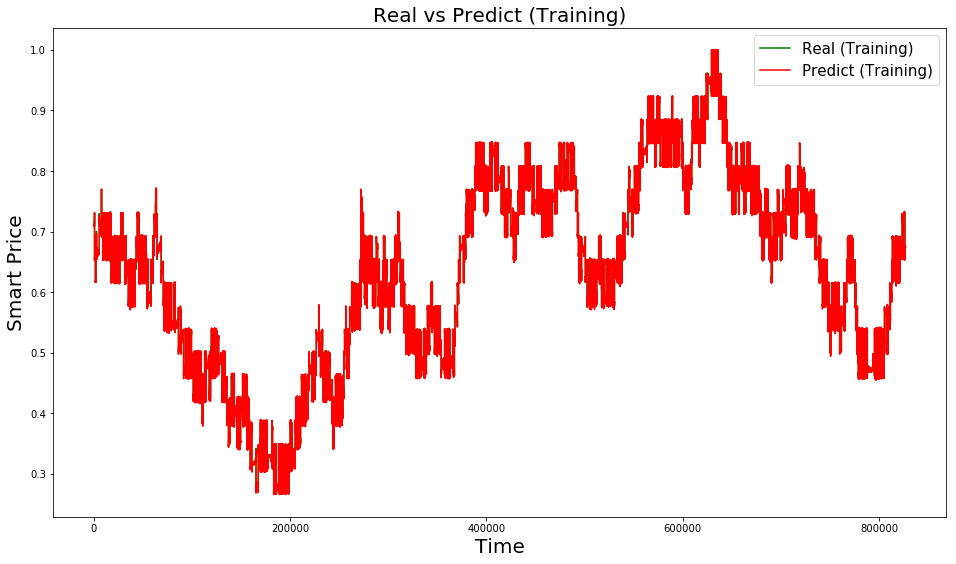

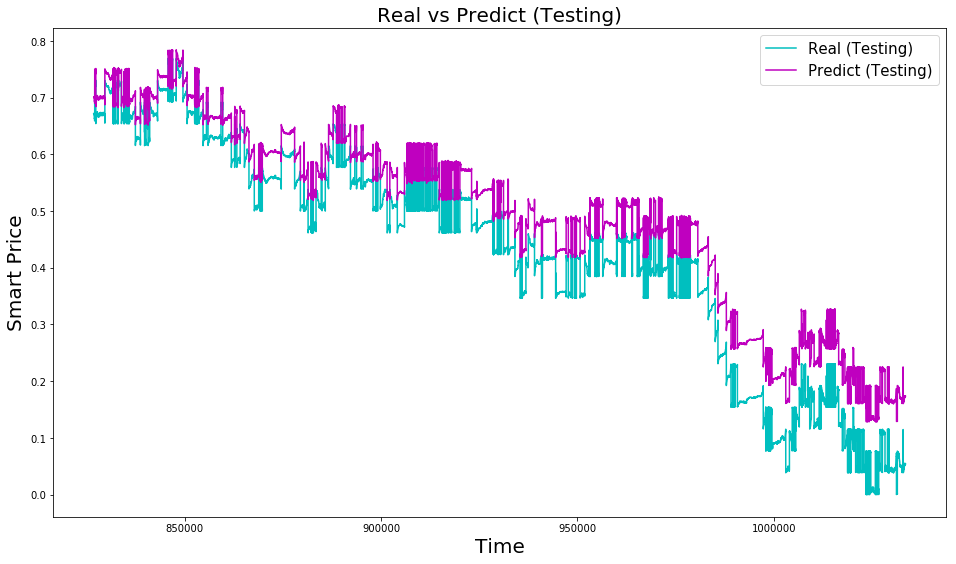

In [29]:
fig = plt.figure(figsize=(16,9))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="g", label="Real (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], pred_train[:, 0], color="r", label="Predict (Training)")
plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Training)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Smart Price', fontsize=20)


fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="c", label="Real (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="m", label="Predict (Testing)")
plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Smart Price', fontsize=20)

plt.show()

In [30]:
# calculate root mean squared error
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], pred_train[:, 0])
print MSE_train
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], pred_test[:, 0])
print MSE_test

1.551549077651991e-05
0.004966493149427355
